In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\shivam.al.kumar\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score,confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict

In [3]:
# from catboost import CatBoostClassifier
from catboost import *
# from imblearn.over_sampling import SMOTE

In [4]:
import optuna
from optuna.samplers import TPESampler

In [5]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [6]:
df_train = pd.read_csv("train_2024_03_15_09_17_35.csv", sep=";")

In [7]:
df_test=pd.read_csv("test_2024_03_22_07_20_32.csv", sep=";")

In [8]:
df_train.head(10)

,ID,Product_ID,Type,Tool_wear_sec,Process_temperature_K,Air_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Failure_Type
0,1,L50218,L,1800,309.5,300.4 K,1349,50.4,30,0
1,2,L47518,L,900,308.2,297.5 K,1563,38.2,15,0
2,3,L49755,L,10740,309.3,299.5 K,1422,49.2,179,0
3,4,H31191,H,2160,308.2,298.6 K,1555,36.8,36,0
4,5,L52805,L,8760,312.1,302.7 K,3012,24.4,146,0
5,6,L48024,L,12360,307.5,296.5 K,1566,35.1,206,0
6,7,M24689,M,12180,309.4,298.4 K,1429,41.8,203,0
7,8,L50511,L,8100,310.8,301.7 K,1559,44.5,135,0
8,9,M24474,M,5640,310.3,299.1 K,1441,43.9,94,0
9,10,H38831,H,360,308.4,298.1 K,3144,43.8,6,0


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     7000 non-null   int64  
 1   Product_ID             7000 non-null   object 
 2   Type                   7000 non-null   object 
 3   Tool_wear_sec          7000 non-null   int64  
 4   Process_temperature_K  6924 non-null   float64
 5   Air_temperature_K      7000 non-null   object 
 6   Rotational_speed_rpm   7000 non-null   int64  
 7   Torque_Nm              7000 non-null   object 
 8   Tool_wear_min          7000 non-null   int64  
 9   Failure_Type           7000 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 547.0+ KB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     3000 non-null   int64  
 1   Product_ID             3000 non-null   object 
 2   Type                   3000 non-null   object 
 3   Tool_wear_sec          3000 non-null   int64  
 4   Process_temperature_K  2970 non-null   float64
 5   Air_temperature_K      3000 non-null   object 
 6   Rotational_speed_rpm   3000 non-null   int64  
 7   Torque_Nm              3000 non-null   object 
 8   Tool_wear_min          3000 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 211.1+ KB


In [11]:
df_train.drop('ID', inplace=True, axis=1)
df_test.drop('ID', inplace=True, axis=1)

In [12]:
df_train['Air_temperature_K'] = df_train['Air_temperature_K'].str[0:-2].astype('float')

In [13]:
df_train['Torque_Nm'] = df_train['Torque_Nm'].replace('Sixty two','62')
df_train['Torque_Nm'] = df_train['Torque_Nm'].replace('Eight','8')
df_train['Torque_Nm'] = df_train['Torque_Nm'].replace('Thirty','30')
df_train['Torque_Nm'] = df_train['Torque_Nm'].astype(float)

In [14]:
df_train.fillna(method='bfill',inplace=True)

In [15]:
# for test
df_test['Air_temperature_K'] = df_test['Air_temperature_K'].str[0:-2].astype('float')
df_test['Torque_Nm'] = df_test['Torque_Nm'].replace('Sixty two','62')
df_test['Torque_Nm'] = df_test['Torque_Nm'].replace('Eight','8')
df_test['Torque_Nm'] = df_test['Torque_Nm'].replace('Thirty','30')
df_test['Torque_Nm'] = df_test['Torque_Nm'].astype(float)
df_test.fillna(method='bfill',inplace=True)

### Product Id transformation

In [16]:
df_train['Product_ID'] = df_train['Product_ID'].str[1:].astype(int)

In [17]:
df_test['Product_ID'] = df_test['Product_ID'].str[1:].astype(int)

In [18]:
# OHE of Type feature of df_train
df_train = pd.concat([df_train, pd.get_dummies(df_train['Type'], prefix='Type').astype(int)], axis=1)
df_train.drop('Type', axis=1, inplace=True)

In [19]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['Type'], prefix='Type').astype(int)], axis=1)
df_test.drop('Type', axis=1, inplace=True)

In [20]:
# df_train.iloc[:,1:6].plot(kind='box', subplots=True, layout=(3, 3), sharex=False, sharey=False)
# plt.rcParams['figure.figsize'] = (14, 14)
# plt.show()

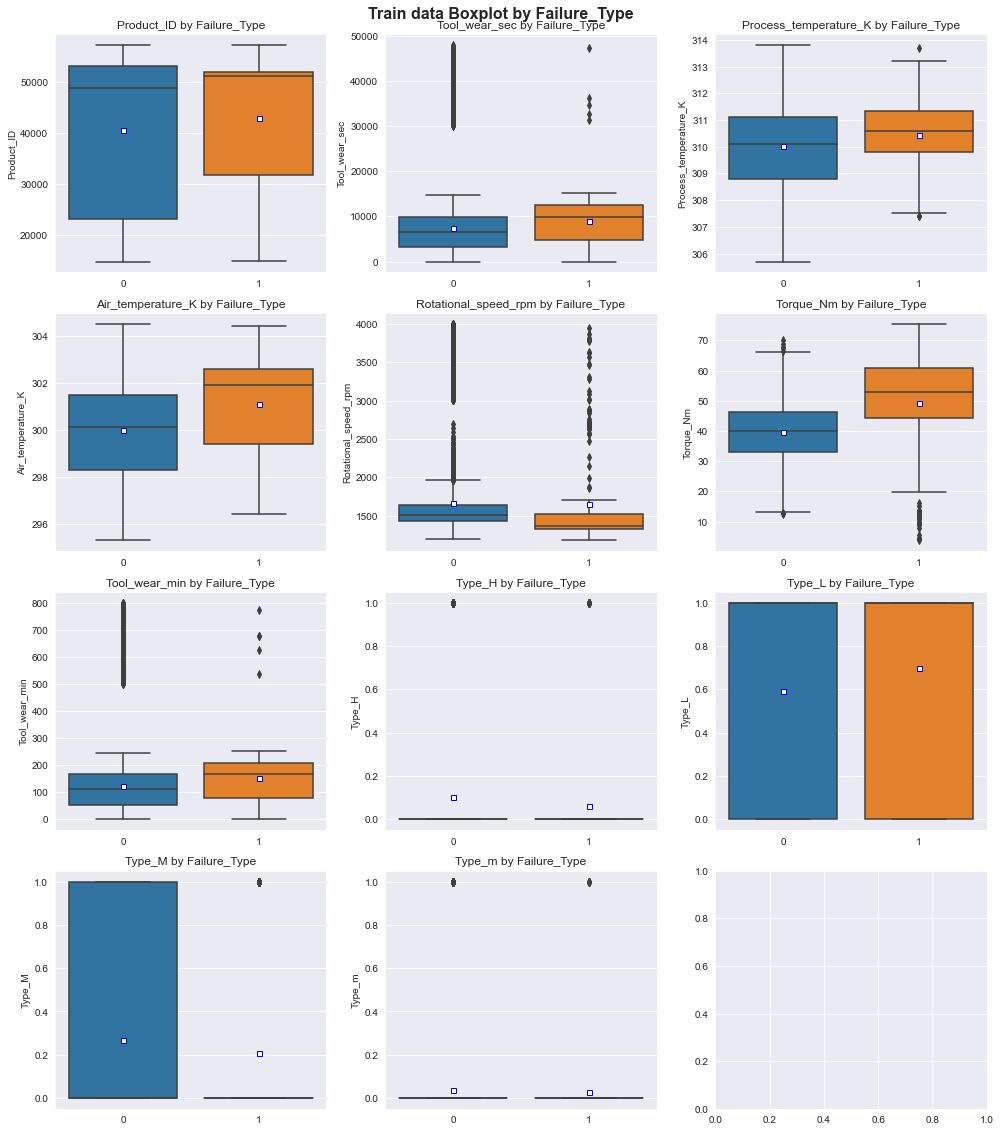

In [21]:
# Density function for each feature of the training data without id column
# kdedf=df_train.iloc[:,1:6]
# sns.kdeplot(data=kdedf,x=kdedf['Air_temperature_K'].to_numpy())
def plot_boxplot(df, hue, title='', drop_cols=[], n_cols=3):
    sns.set_style('darkgrid')

    cols = df.columns.drop([hue] + drop_cols)
    n_rows = (len(cols) - 1) // n_cols + 1

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4*n_rows))

    for i, var_name in enumerate(cols):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]
        sns.boxplot(data=df, x=hue, y=var_name, ax=ax, showmeans=True, 
                    meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
        ax.set_title(f'{var_name} by {hue}')
        ax.set_xlabel('')

    fig.suptitle(f'{title} Boxplot by {hue}', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
    
plot_boxplot(df_train, hue='Failure_Type', n_cols=3, title='Train data')



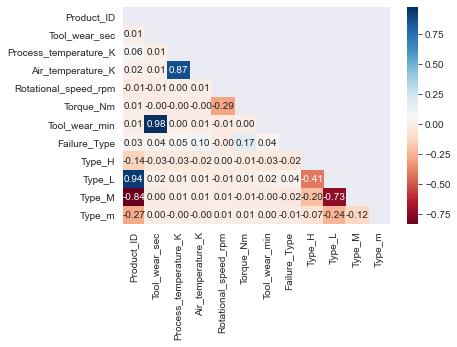

In [22]:
# Correlation matrix for the training data with only inferior triangle
corr = df_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap='RdBu', annot=True, fmt='.2f')
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

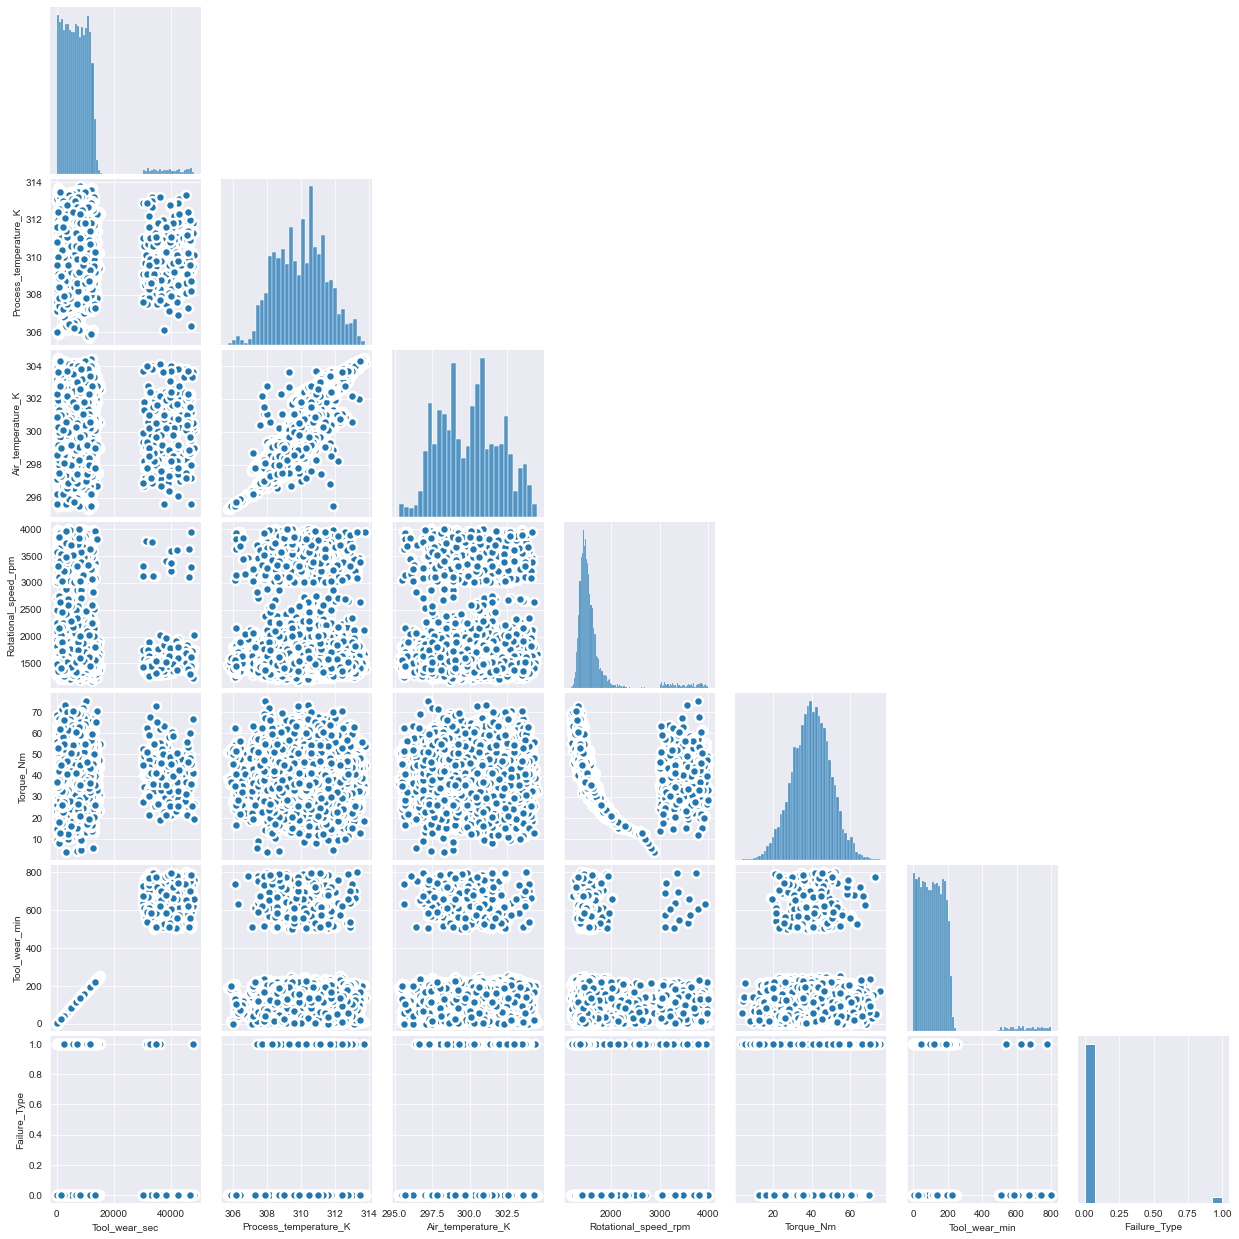

In [23]:
# matrix of scatter and histograms for each feature of the training data 
sns.pairplot(data=df_train.iloc[:,1:8], corner=True, plot_kws={'s':80, 'edgecolor':"white", 'linewidth':2.5})
plt.show()

In [24]:
df_train.nunique().sort_values()

Failure_Type                2
Type_H                      2
Type_L                      2
Type_M                      2
Type_m                      2
Process_temperature_K      82
Air_temperature_K          93
Tool_wear_min             400
Tool_wear_sec             406
Torque_Nm                 552
Rotational_speed_rpm     1225
Product_ID               7000
dtype: int64

In [25]:
df_train_FE=df_train.copy()
df_test_FE=df_test.copy()

In [26]:
## feature engineering
def feature_engineering(df):
    df['RelationTemperature'] = df['Air_temperature_K'] / df['Process_temperature_K']
    df['TorqueRPM'] = df['Torque_Nm'] / df['Rotational_speed_rpm']
    df['WearRPM'] = df['Tool_wear_min'] / df['Rotational_speed_rpm']
    df['ToolWearTorque'] = df['Tool_wear_min'] / df['Torque_Nm']

    for col in ['Torque_Nm', 'Tool_wear_min', 'Rotational_speed_rpm']:
        df[f'{col}_B'] = pd.cut(df[col], bins=20)
        df[f'{col}_B'] = df[f'{col}_B'].cat.codes + 1

    

    Angular_velocity = df['Rotational_speed_rpm'] * 2 * np.pi / 60

    df['Power_W'] = df['Torque_Nm'] * Angular_velocity
    
    df['Energy_J'] = df['Power_W'] * df['Tool_wear_min'] *60

    return df

In [27]:
df_train_FE=feature_engineering(df_train_FE)
df_test_FE=feature_engineering(df_test_FE)

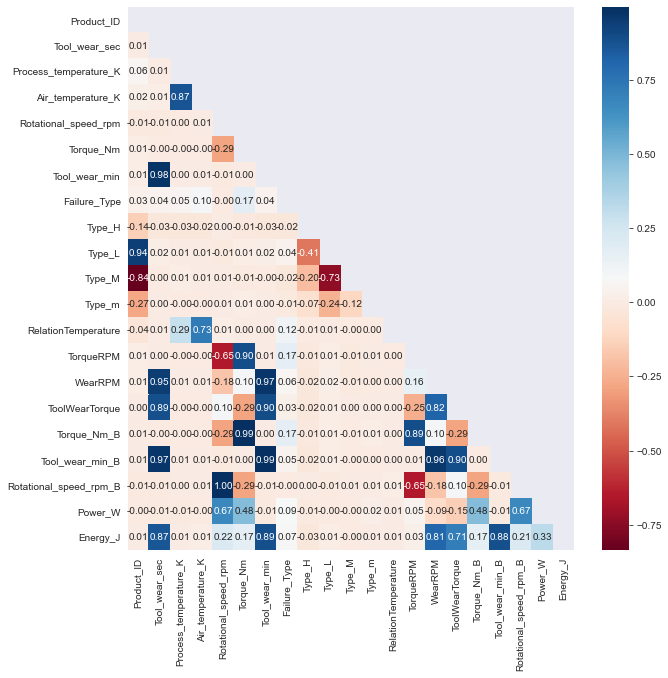

In [28]:
corr = df_train_FE.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, cmap='RdBu', annot=True, fmt='.2f')
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [29]:
Best_XGB =  {'max_depth': 13, 
         'learning_rate': 0.012308520402322306, 
         'colsample_bytree': 0.15564433647290904, 
         'subsample': 0.9392376085401448, 
         'n_estimators': 494, 
         'min_child_weight': 1, 
         'reg_alpha': 0.26760253520809857, 
         'reg_lambda': 0.24616802866656362}

In [30]:
df_train.head()

,Product_ID,Tool_wear_sec,Process_temperature_K,Air_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Failure_Type,Type_H,Type_L,Type_M,Type_m
0,50218,1800,309.5,300.4,1349,50.4,30,0,0,1,0,0
1,47518,900,308.2,297.5,1563,38.2,15,0,0,1,0,0
2,49755,10740,309.3,299.5,1422,49.2,179,0,0,1,0,0
3,31191,2160,308.2,298.6,1555,36.8,36,0,1,0,0,0
4,52805,8760,312.1,302.7,3012,24.4,146,0,0,1,0,0


In [31]:
y_train=df_train_FE['Failure_Type']
X_train=df_train_FE.drop('Failure_Type',axis=1)

In [32]:
def ROC_AUC(model, X_train, y_train, n_splits=5, n_repeats=3):
    
    # Initialize the Repeated Stratified K Fold
    rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    # Create an empty list to store the Out-of-Fold (OOF) predictions
    oof_preds = np.zeros(X_train.shape[0])

    # Loop through each split
    for train_index, valid_index in rskf.split(X_train, y_train):
    
        # Split the data
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
    
        # Fit the model
        model.fit(X_train_fold, y_train_fold)
    
        # Make predictions and add them to the OOF predictions
        oof_preds[valid_index] = model.predict_proba(X_valid_fold)[:,1]

    # Calculate the overall AUC
    auc = roc_auc_score(y_train, oof_preds)

    return auc

In [33]:
"""cat_cv_scores  = list()

def objective(trial):
    params = {
        'eval_metric': 'AUC',
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'depth': trial.suggest_int('depth', 3, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'boosting_type': 'Ordered',
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 8),
        'iterations': trial.suggest_int('iterations', 300, 1000),
        'subsample': trial.suggest_float('subsample', 0.1, 0.9)
    }
    earlystop_params = params.copy()
    earlystop_params.update({
        'od_type': 'Iter',
        'od_wait': 60
    })
    
    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    
    for i, (train_ix, test_ix) in enumerate(skf.split(X_train, y_train)):
        
        print("=======================================================================")
        
        X_traino, X_testo = X_train.iloc[train_ix], X_train.iloc[test_ix]
        y_traino, y_testo = y_train.iloc[train_ix], y_train.iloc[test_ix]
    traino_pool    = Pool(X_traino.to_numpy(), y_traino.to_numpy(), feature_names = features_names_list, cat_features = ['Type', 'Product ID'])
        testo_pool      = Pool(X_testo.to_numpy(), y_testo.to_numpy(),     feature_names = features_names_list, cat_features = ['Type', 'Product ID'])

        optuna_model = CatBoostClassifier(**earlystop_params, random_seed=42)
        optuna_model.fit(traino_pool, verbose=0, eval_set=testo_pool)
        
        y_pred = optuna_model.predict_proba(testo_pool)
        cat_score_fold = eval_metric(testo_pool.get_label(), y_pred[:, 1], 'AUC')   
        cat_cv_scores.append(cat_score_fold)

        print('Fold N°', i, '==> CatBoost       - AUC: ====>', cat_score_fold)
    
    return np.mean(cat_cv_scores)
    
    sampler = TPESampler(seed=123)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=15)"""

'cat_cv_scores  = list()\n\ndef objective(trial):\n    params = {\n        \'eval_metric\': \'AUC\',\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.001, 0.3),\n        \'depth\': trial.suggest_int(\'depth\', 3, 15),\n        \'l2_leaf_reg\': trial.suggest_float(\'l2_leaf_reg\', 1, 10),\n        \'boosting_type\': \'Ordered\',\n        \'max_ctr_complexity\': trial.suggest_int(\'max_ctr_complexity\', 0, 8),\n        \'iterations\': trial.suggest_int(\'iterations\', 300, 1000),\n        \'subsample\': trial.suggest_float(\'subsample\', 0.1, 0.9)\n    }\n    earlystop_params = params.copy()\n    earlystop_params.update({\n        \'od_type\': \'Iter\',\n        \'od_wait\': 60\n    })\n    \n    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)\n    \n    for i, (train_ix, test_ix) in enumerate(skf.split(X_train, y_train)):\n        \n        print("=======================================================================")\n        \n        X_traino, X

In [34]:
model_XGB = xgb.XGBClassifier(**Best_XGB)
model_XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.15564433647290904, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.012308520402322306,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=494, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [35]:
params ={'loss_function': 'Logloss',
         'eval_metric': 'AUC',
         'random_seed': 42,
         'learning_rate': 0.027, 
          'iterations': 927, 
          'depth': 5, 
          'subsample': 0.705
        }

In [36]:
model_CatB = CatBoostClassifier(**params)
model_CatB.fit(X_train, y_train)

0:	total: 147ms	remaining: 2m 16s
1:	total: 153ms	remaining: 1m 10s
2:	total: 158ms	remaining: 48.6s
3:	total: 163ms	remaining: 37.6s
4:	total: 168ms	remaining: 31s
5:	total: 174ms	remaining: 26.7s
6:	total: 180ms	remaining: 23.6s
7:	total: 186ms	remaining: 21.3s
8:	total: 192ms	remaining: 19.6s
9:	total: 198ms	remaining: 18.1s
10:	total: 203ms	remaining: 16.9s
11:	total: 208ms	remaining: 15.9s
12:	total: 213ms	remaining: 15s
13:	total: 218ms	remaining: 14.2s
14:	total: 223ms	remaining: 13.5s
15:	total: 227ms	remaining: 12.9s
16:	total: 233ms	remaining: 12.4s
17:	total: 237ms	remaining: 12s
18:	total: 242ms	remaining: 11.6s
19:	total: 247ms	remaining: 11.2s
20:	total: 251ms	remaining: 10.8s
21:	total: 256ms	remaining: 10.5s
22:	total: 261ms	remaining: 10.3s
23:	total: 266ms	remaining: 9.99s
24:	total: 270ms	remaining: 9.75s
25:	total: 275ms	remaining: 9.53s
26:	total: 280ms	remaining: 9.33s
27:	total: 285ms	remaining: 9.15s
28:	total: 290ms	remaining: 8.98s
29:	total: 295ms	remaining: 

In [37]:
AUC_XGB = ROC_AUC(model_XGB, X_train, y_train)
print("AUC XGB: ", AUC_XGB)

AUC XGB:  0.9595656605476028


In [38]:
AUC_CatB = ROC_AUC(model_CatB, X_train, y_train)
print("AUC CatB: ", AUC_CatB)

0:	total: 5.55ms	remaining: 5.14s
1:	total: 11.6ms	remaining: 5.38s
2:	total: 17.1ms	remaining: 5.28s
3:	total: 23ms	remaining: 5.31s
4:	total: 29.1ms	remaining: 5.37s
5:	total: 34.6ms	remaining: 5.32s
6:	total: 40.4ms	remaining: 5.3s
7:	total: 45.2ms	remaining: 5.2s
8:	total: 49.9ms	remaining: 5.08s
9:	total: 55ms	remaining: 5.04s
10:	total: 59.6ms	remaining: 4.96s
11:	total: 64.1ms	remaining: 4.89s
12:	total: 68.9ms	remaining: 4.84s
13:	total: 73.9ms	remaining: 4.82s
14:	total: 78.5ms	remaining: 4.77s
15:	total: 83.1ms	remaining: 4.73s
16:	total: 87.9ms	remaining: 4.71s
17:	total: 92.7ms	remaining: 4.68s
18:	total: 97.5ms	remaining: 4.66s
19:	total: 102ms	remaining: 4.63s
20:	total: 107ms	remaining: 4.6s
21:	total: 111ms	remaining: 4.58s
22:	total: 116ms	remaining: 4.58s
23:	total: 121ms	remaining: 4.55s
24:	total: 126ms	remaining: 4.53s
25:	total: 131ms	remaining: 4.54s
26:	total: 135ms	remaining: 4.51s
27:	total: 140ms	remaining: 4.49s
28:	total: 144ms	remaining: 4.47s
29:	total: 1

In [39]:
data_cat=Pool(data=X_train, label=y_train)

In [40]:
feature_importances = model_CatB.get_feature_importance(data_cat)
feature_names = X_train.columns

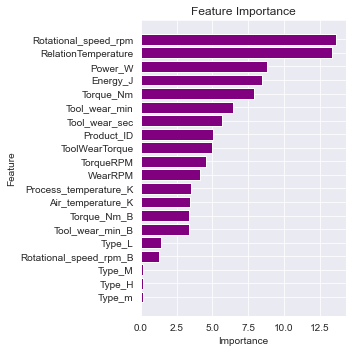

In [41]:
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=True) 
plt.figure(figsize=(5, 5))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'],color='purple')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

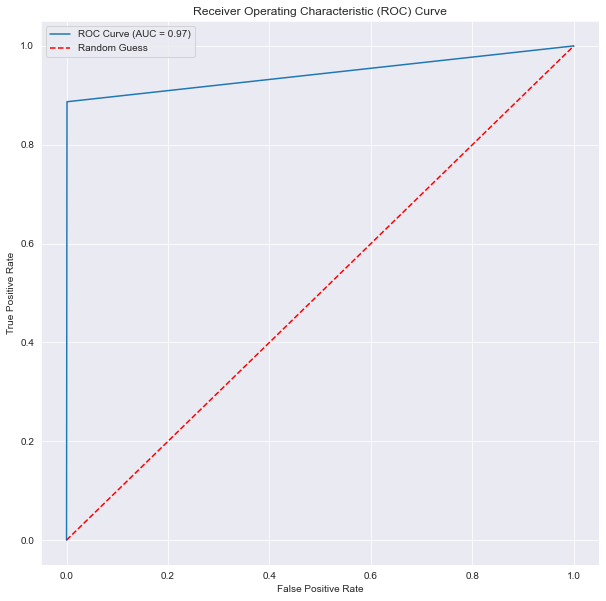

In [42]:
# Plot ROC curve
y_train_pred=model_CatB.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {AUC_CatB:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [43]:
cm = confusion_matrix(y_train,y_train_pred)

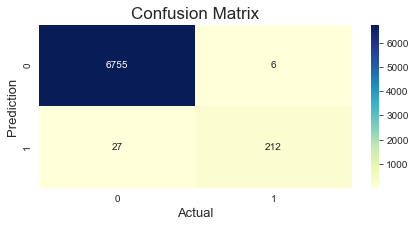

In [64]:
fig, ax = plt.subplots(figsize=(7,3))  
sns.heatmap(cm, cmap="YlGnBu",
            annot=True,
            fmt='g', ax=ax)
# plt.figure(figsize=(10,5))
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [45]:
df_test.head()

,Product_ID,Tool_wear_sec,Process_temperature_K,Air_temperature_K,Rotational_speed_rpm,Torque_Nm,Tool_wear_min,Type_H,Type_L,Type_M,Type_m
0,18951,8100,310.4,302.0,1595,32.9,135,0,0,1,0
1,48990,7740,307.6,298.1,1364,53.8,129,0,1,0,0
2,50515,8760,310.9,301.7,1705,31.2,146,0,1,0,0
3,55162,6420,312.3,301.0,1488,42.6,107,0,1,0,0
4,48366,1860,308.4,297.3,1417,47.8,31,0,1,0,0


In [46]:
y_pred_test = model_XGB.predict(df_test_FE)

In [47]:
y_pred_test_cat = model_CatB.predict(df_test_FE)

In [48]:
df_submission_t=pd.read_csv("test_2024_03_22_07_20_32.csv", sep=";")

In [49]:
df_submission=pd.DataFrame({'id': df_submission_t['ID'], 'Failure_Type': y_pred_test})

In [50]:
df_submission.head()

,id,Failure_Type
0,7001,0
1,7002,0
2,7003,0
3,7004,0
4,7005,0


In [51]:
df_submission.Failure_Type.sum()

33

In [52]:
y_pred_test_cat

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [53]:
df_submission=pd.DataFrame({'id': df_submission_t['ID'], 'Failure_Type': y_pred_test_cat})